## Exploratory Data Analysis

In [36]:
#imports
import nltk
nltk.download('vader_lexicon')
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import datetime as dt

from wordcloud import WordCloud, STOPWORDS


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MSI_PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# create the dataframe
cwd = os.getcwd()
df = pd.read_csv(cwd+"/cleaned-BA-reviews.csv", index_col=0)

#let's also check the index are in order
df = df.reset_index(drop=True)

In [6]:
df.head()

reviews  stars        date  \
0  ✅ Trip Verified |  This flight was one of the ...      5  2023-01-21   
1  Not Verified | It seems that there is a race t...      2  2023-01-19   
2  Not Verified |  As a Spanish born individual l...      3  2023-01-19   
3  ✅ Trip Verified |  A rather empty and quiet fl...      2  2023-01-18   
4  ✅ Trip Verified |  Easy check in and staff mem...      9  2023-01-17   

          country  verified                                             corpus  
0  United Kingdom      True  flight one worst ever life wanted pamper bough...  
1   United States     False  verified seems race bottom amongst airline can...  
2  United Kingdom     False  verified spanish born individual living englan...  
3  United Kingdom      True  rather empty quiet flight tel aviv friendly ca...  
4  United Kingdom      True  easy check staff member polite helpful made sp...

#### What is the average overall rating given for British Airways?

In [7]:
df.stars.mean()

4.81559659923776

#### What is the total counts for each ratings?


Text(0.5, 0.98, 'Counts for each ratings')

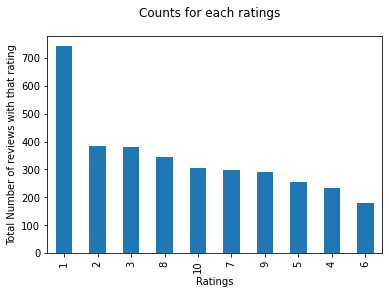

In [8]:
df.stars.value_counts().plot(kind="bar")
plt.xlabel("Ratings")
plt.ylabel("Total Number of reviews with that rating")
plt.suptitle("Counts for each ratings")

In [9]:
df_ratings = pd.DataFrame(df.stars.value_counts())
pct_values = (df_ratings.stars.values/ df_ratings.stars.values.sum() *100).tolist()
pct_values = [round(x,2) for x in pct_values]
df_ratings['pct_values'] = pct_values

In [10]:
#resetting index as we do not want to confuse between the index and the rating values
df_ratings = df_ratings.reset_index()

In [11]:
# renaming columns
df_ratings.rename(columns={'index':'Stars', 'stars':'total_counts'}, inplace=True)

In [425]:
df_ratings

Stars  total_counts  pct_values
0      1           735       21.55
1      2           382       11.20
2      3           379       11.11
3      8           349       10.23
4     10           306        8.97
5      7           299        8.77
6      9           293        8.59
7      5           259        7.59
8      4           227        6.65
9      6           182        5.34

Text(0.5, 1.0, 'Counts for each ratings')

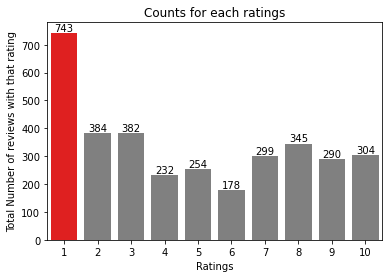

In [12]:

clrs = ['Red' if (x ==  max(df_ratings.total_counts)) else 'grey' for x in df_ratings.total_counts ]
ax = sns.barplot(x=df_ratings.Stars, y=df_ratings.total_counts, data=df_ratings, errwidth=0,
                palette=clrs)


ax.bar_label(ax.containers[0])
    
ax.set_xlabel("Ratings")
ax.set_ylabel("Total Number of reviews with that rating")
ax.set_title("Counts for each ratings")


In [13]:
# Unique countries BA recieved the reviews from

print(f"{len(df.country.unique())} unique countries")

69 unique countries


#### Which country most review comes from?  

In [14]:
df_country_review = pd.DataFrame(df.country.value_counts().head()).reset_index()

In [15]:
df_country_review.rename(columns={'index':'country','country':'total_reviews'}, inplace=True)

Text(0.5, 1.0, 'Maximum number of review by country')

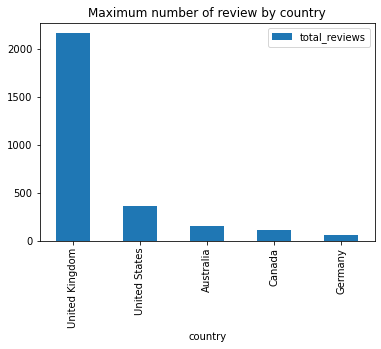

In [16]:
df_country_review.plot(kind="bar", x='country')
plt.title("Maximum number of review by country")

#### Which country provided on average highest ratings?

In [17]:
df_country_rating = pd.DataFrame(df.groupby('country').mean()['stars'].sort_values(ascending=False)).reset_index()

In [18]:
df_country_rating.rename(columns={'stars':'avg_rating'}, inplace=True)


Text(0.5, 1.0, 'Top 12 Countries with avg highest rating provided to British Airways')

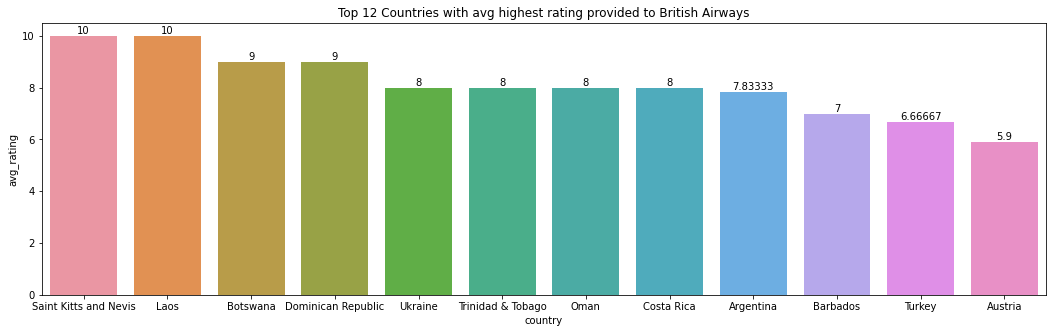

In [19]:
fig, ax = plt.subplots(figsize=(18,5))
ax1 = sns.barplot(x='country', y='avg_rating', data=df_country_rating[:12])
ax.bar_label(ax.containers[0])
ax.set_title("Top 12 Countries with avg highest rating provided to British Airways")

#### Time Series Analysis

In [20]:
#convert the date datatype to datetime

df.date = pd.to_datetime(df.date)

In [21]:
fig = px.line(df, x='date', y="stars")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

It can be seen that between April 2020 to August 2021 there has been a decline in reviews due to Covid Pandemic travel restrictions. Not much can be inferred at this point as the dates we have are the when the customers posted their reviews which does not take into account the actual flight date. Hence no particular significan trend is visible from the plot.

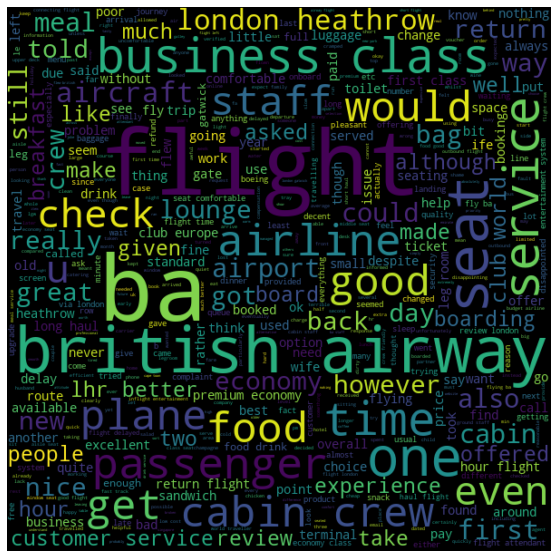

In [22]:
import nltk
from nltk.corpus import stopwords
# Start with one review:
reviews = " ".join(df.corpus)
plt.figure(figsize=(20,10))

stopwords = set(stopwords.words('english'))

# Create and generate a word cloud image:
wordcloud = WordCloud(height=600,width=600,max_font_size=100, max_words=500, stopwords=stopwords).generate(reviews)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are many words that does not set the idea of whether the review is positive or negative. For example words like "passenger", "flight", etc. does not add conlcusive value hence we can include them in stopwords list. 


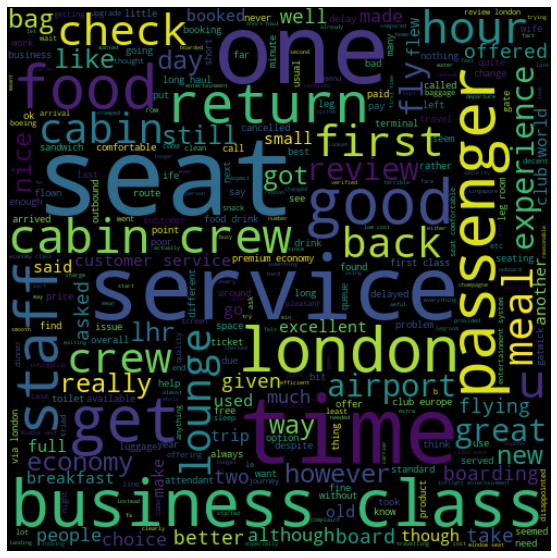

In [23]:
import nltk
from nltk.corpus import stopwords
reviews = " ".join(df.corpus)
plt.figure(figsize=(20,10))

stopwords = set(stopwords.words('english'))
stopwords.update(["ba","flight", "british","airway", "airline","plane", "told","also","passenger" \
                 "london", "heathrow", "aircraft", "could","even", "would"])
# Create and generate a word cloud image:
wordcloud = WordCloud(height=500,width=500,max_font_size=100, max_words=300, stopwords=stopwords).generate(reviews)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Frequency

In [24]:
from nltk import ngrams
from nltk.probability import FreqDist

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

#split the text of all reviews into a list of words
words = reviews.split(" ")

#remove certain words that will not be used to determine the positive or negative sentiment
stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'ba', "passenger","u", "london","airway","british","airline",\
                                           "heathrow","plane","lhr","review"])


new_words = [word for word in words if word not in stopwords]

nlp_words=FreqDist(new_words).most_common(20)

#create a dataframe of these word and its frequencies
all_fdist = pd.Series(dict(nlp_words))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'seat'),
  Text(1, 0, 'service'),
  Text(2, 0, 'time'),
  Text(3, 0, 'food'),
  Text(4, 0, 'crew'),
  Text(5, 0, 'good'),
  Text(6, 0, 'cabin'),
  Text(7, 0, 'class'),
  Text(8, 0, 'hour'),
  Text(9, 0, 'business'),
  Text(10, 0, 'staff'),
  Text(11, 0, 'economy'),
  Text(12, 0, 'check'),
  Text(13, 0, 'drink'),
  Text(14, 0, 'meal'),
  Text(15, 0, 'lounge'),
  Text(16, 0, 'return'),
  Text(17, 0, 'club'),
  Text(18, 0, 'boarding'),
  Text(19, 0, 'experience')])

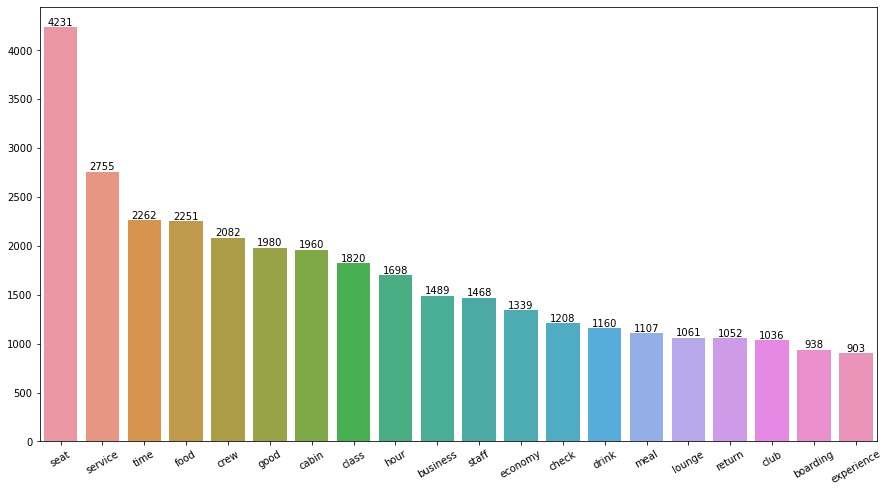

In [25]:
## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15,8))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
all_plot.bar_label(all_plot.containers[0])
plt.xticks(rotation=30)

This gives us a glimpse of what customers are really talking about here. We see that Seat is most talked about the airline followed by "Service" and "food" which are all very important to customers in terms of service. However, we still do not know is how they are expressing about each of this service. To bring some significane to these terms we will use ngram plots to see if they are bad or good in experience. 

## Word Frequency with N-gram

<AxesSubplot:>

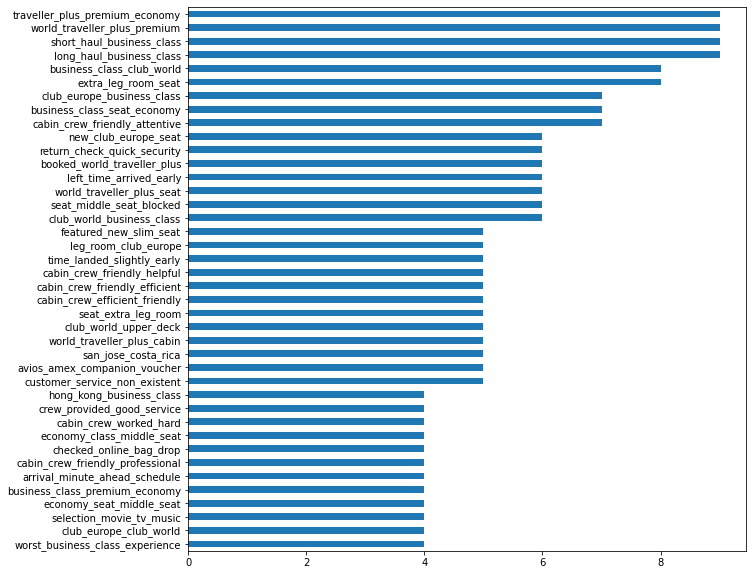

In [26]:
## Imports
import nltk.collocations as collocations
from nltk import FreqDist, bigrams

reviews = " ".join(df.corpus)

#split the text of all reviews into a list of words
words = reviews.split(" ")

new_words = [word for word in words if word not in stopwords]

def get_freq_dist(new_words,number_of_ngrams ):
    from nltk import ngrams
    
    ## Generate bigrams
    ngrams = ngrams(new_words, number_of_ngrams)

    ## Creating FreqDist
    ngram_fd = FreqDist(ngrams).most_common(40)

    ## Sort values by highest frequency
    ngram_sorted = {k:v for k,v in sorted(ngram_fd, key=lambda item:item[1])}

    ## Join bigram tokens with '_' + maintain sorting
    ngram_joined = {'_'.join(k):v for k,v in sorted(ngram_fd, key=lambda item:item[1])}

    ## Convert to Pandas series for easy plotting
    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10,10))
    ax = ngram_freqdist.plot(kind="barh")
    
    return ax


get_freq_dist(new_words,4)

We can see that there are very common positive terms regarding cabin crew. For example, cabin_crew_friendly_helpful, cabin_crew_friendly_attentive, cabin_crew_friendly_efficient, etc. So certainly customers are providing good reviews about cabin crew staff of British Airways. 

However, there is one another approach that we can try to find the word frequencies which will give us better idea. We will group the reviews based on ratings. Say, we assume ratigs 1-3 are bad reviews, 4-6 are average/good experience and 7-10 indicates a great experience. 

In [27]:
ratings_1_3 = df[df.stars.isin([1,2,3])]
ratings_4_6 = df[df.stars.isin([4,5,6])]
ratings_7_10 = df[df.stars.isin([7,8,9,10])]

<AxesSubplot:>

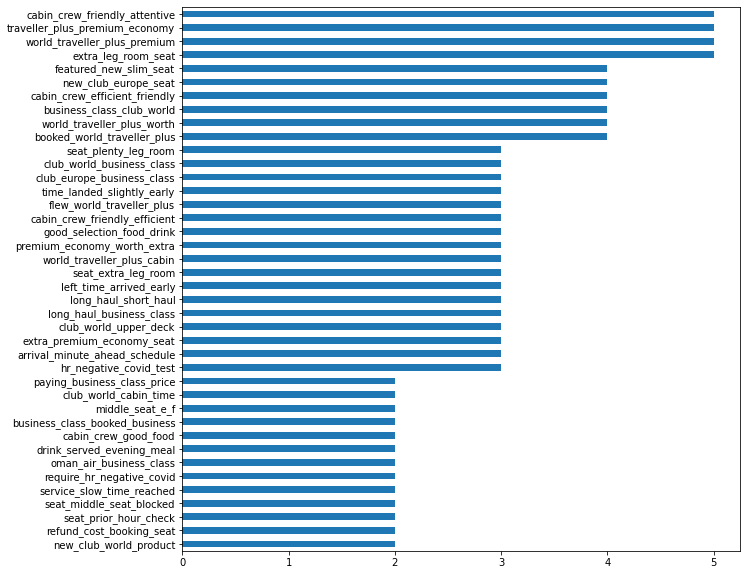

In [28]:
reviews_1_3 = " ".join(ratings_1_3.corpus)
reviews_4_6 = " ".join(ratings_4_6.corpus)
reviews_7_10 = " ".join(ratings_7_10.corpus)

#split the text of all reviews into a list of words
words_1_3 = reviews_1_3.split(" ")
words_4_6 = reviews_4_6.split(" ")
words_7_10 = reviews_7_10.split(" ")


new_words_7_10 = [word for word in words_7_10 if word not in stopwords]

get_freq_dist(new_words_7_10,4)

<AxesSubplot:>

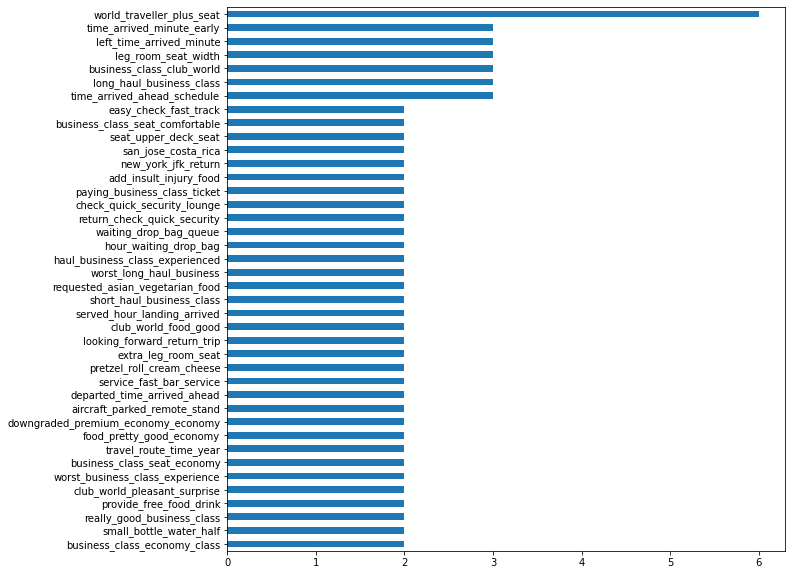

In [29]:

new_words = [word for word in words_4_6 if word not in stopwords]

get_freq_dist(new_words,4)

<AxesSubplot:>

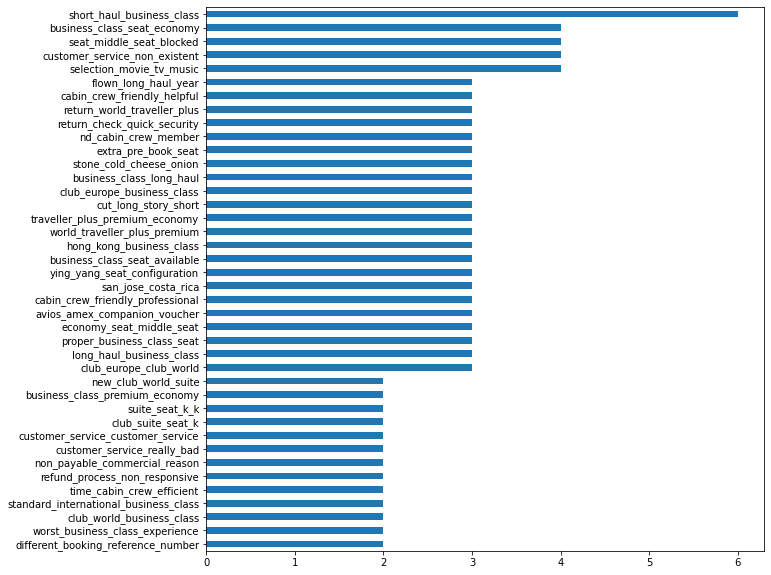

In [30]:
new_words = [word for word in words_1_3 if word not in stopwords]

get_freq_dist(new_words,4)

****

Now we will use textblob library to define if the text is negative or positive and to what extent


In [32]:
%%capture
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

#set a column Polarity with all 0 values initially
df['polarity'] = 0

for i in range(len(df.corpus)):
    sent= TextBlob(df.corpus[i])
    polarity  = sent.sentiment.polarity
    subjectivity  = sent.sentiment.subjectivity
    df['polarity'][i] = polarity

In [33]:
# let's see how many texts are with positive comments

print(f"{df[(df['polarity'] >-0.2) & (df['polarity'] <0.2)].shape[0]} number of reviews between -0.2 and 0.2 polarity score")

print(f"{df[(df['polarity'] >-0.1) & (df['polarity'] <0.1)].shape[0]} number of reviews between -0.1 and 0.1 polarity score")


3411 number of reviews between -0.2 and 0.2 polarity score
3411 number of reviews between -0.1 and 0.1 polarity score


Polarity score is given between -1 to 1 and more close the value to -1, it indicates negative review and vice versa is true for positive value. If we consider a threshold where any review with polarity greater than 0.2 is positive and less than -0.2 is negative, we are left with 2286 reviews that lies in the neutral zone. To further narrow down this number of neutral reviews, let's take the threshold of 0.1. 

We will try another method of labelling the reveiws as positives or negatives. In this we will use VADER algorihtm by nltk library. 

In [37]:
%%capture
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer 
vds = SentimentIntensityAnalyzer()
# text = 'This is an extremely entertaining movie'

#set a column Polarity with all 0 values initially
df['label'] = 0
    
for i in range(len(df.corpus)):
    
    score = vds.polarity_scores(df.corpus[i])['compound']
    #print(score)
    if score > 0.2:
        df['label'][i] = 1
        #print("1st")
    elif score < 0:
        df['label'][i] = -1
        #print("2nd")
    else:
        df['label'][i] = 0

In [38]:
df.label.value_counts()

 1    2235
-1    1059
 0     117
Name: label, dtype: int64

## Topic Modeling with LDA
We have already cleaned our reviews, however, for topic modeling we will also require word embeddings or (words matrix). For this purpose we will use count vectorizer method from sklearn library. 

In [39]:
%%capture
from sklearn.feature_extraction.text import CountVectorizer

#create an object of count vectorizer
vect = CountVectorizer()

#apply transformation
tf = vect.fit_transform(df.corpus).toarray()
tf_feature_names = vect.get_feature_names()


In [40]:
from sklearn.decomposition import LatentDirichletAllocation

#declare the number of topics
number_of_topics = 8

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

#fit the term frequency data to the model
model.fit(tf)

#create empty dictionary to store key value pair of topic number and its weights
topic_dict = {}

#loop through model components 
for topic_idx, topic in enumerate(model.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic =pd.DataFrame(topic_dict)

In [41]:
df_topic

Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights Topic 2 words  \
0         class           226.2        flight           920.7        flight   
1      business           160.0          seat           906.7            ba   
2            ba           113.6          good           904.6          hour   
3         first            83.6          crew           724.7        airway   
4       service            69.5          club           693.9       british   
5          seat            66.5          food           689.6        london   
6          food            60.4            ba           675.8          time   
7         cabin            58.1       service           659.2      customer   
8        flight            57.1        lounge           628.4         would   
9          poor            56.8         cabin           518.3          told   

  Topic 2 weights Topic 3 words Topic 3 weights Topic 4 words Topic 4 weights  \
0          2351.1        flight          2116.6        flight           182.8   
1          1462.3          crew           717.6          meal           169.6   
2           810.3       service           712.1            ba           164.5   
3           680.9          time           704.2          food            96.4   
4           672.0          good           694.5       chicken            94.3   
5           661.2            ba           630.1        choice            89.8   
6           638.3        london           624.0        option            84.0   
7           601.6         cabin           607.3          hour            79.0   
8           596.1      heathrow           555.6          time            77.7   
9           594.0          food           531.2         drink            75.7   

  Topic 5 words Topic 5 weights Topic 6 words Topic 6 weights Topic 7 words  \
0        flight           654.6          seat          1371.5          seat   
1          seat           492.3            ba           830.0         class   
2            ba           461.6        flight           520.5        flight   
3       british           372.1       economy           447.3         cabin   
4        airway           371.8         class           401.2            ba   
5       airline           366.7      business           377.5      business   
6       service           356.3       premium           255.2          food   
7          food           335.7       service           255.1          crew   
8         class           315.3          food           236.0         first   
9      business           296.1           get           227.9           one   

  Topic 7 weights  
0           664.0  
1           404.8  
2           398.6  
3           360.5  
4           283.0  
5           258.6  
6           226.1  
7           220.0  
8           218.9  
9           190.6

There are certain words that are not useful to detect the tone of the reviews overall like "britsh airways", "passenger", "flight", etc.

## Topic modeling with NMF

In [42]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2, init='random', random_state=0)
nmf.fit_transform(tf)

array([[0.05571838, 0.15352823],
       [0.0340309 , 0.03115026],
       [0.03590828, 0.14923459],
       ...,
       [0.0331108 , 0.03671961],
       [0.16517786, 0.08368055],
       [0.18481023, 0.18746351]])

In [43]:
topic_dict = {}

#loop through model components 
for topic_idx, topic in enumerate(nmf.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic =pd.DataFrame(topic_dict)

In [44]:
df_topic

Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights
0          seat            23.2        flight            19.8
1            ba            12.4            ba             6.6
2         class            10.1          hour             4.4
3          food             8.0          time             3.9
4      business             7.9        london             3.5
5       service             7.6       service             3.3
6         cabin             7.5        airway             3.2
7          good             6.8       british             3.1
8          crew             6.6         would             2.8
9       economy             6.2         staff             2.4

With NMF algorithm as well we see there are few words that are not conclusive like "seat". So we will remove such words from the list and try topic modeling again. 